# **Progetto 2**
**GRUPPO 27**
* Fioretto Simone (2002551)
* Guarriello Marco (2024790)


Per la lettura dei file, inserire all'interno nella directory principale del notebook di Colab, le due cartelle zip per i dati di training (`gruppo_0.zip`) e test (`gruppo_27.zip`) e il file csv con le label (`labels_0.csv`).

L’intero codice è implementato in modo tale da essere utilizzabile sia con risorsa CPU, sia con GPU.


# **Estrazione e preparazione dei dati dalla cartella** `gruppo_0` (training)

#### Estrazione da zip, lettura dei file audio, salvataggio dati di training e labels, **normalizzazione tra 0 e 1**

In [ ]:
# Librerie e funzioni per estrazione dei file e trattamento di file audio
import zipfile
import os

from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np

In [ ]:
# Funzione per estrazione file audio -------------------------------------------------------------------------------------------------------------------------
def wav_labels_file_reading (zip, extract_dir):
    with zipfile.ZipFile(zip, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)                                    # estrazione dei file in una nuova cartella
    extracted_files = os.listdir(extract_dir)                            # funzione che estrapola le informazioni dai file contenuti nella cartella
    paths = []                                                           # lista delle stringhe con i nomi dei file
    audio_data = []                                                      # lista dei dati audio
    label = []                                                           # lista delle label
    for i in range(len(labels_df)):                                      # ciclo per i file contenuti nella cartella
        file_path = os.path.join('gruppo_0',labels_df['new_name'][i])    # raccolta nome del file
        label.append(labels_df['original'][i])
        paths.append(file_path)
        sr, data = wavfile.read(file_path)                               # lettura audio e sample rate da file
        audio_data.append((data.astype(float)))                          # creazione array dei dati audio del singolo file
    return  label, sr, paths, audio_data

# Normalizzazione dati audio sul valore massimo presente in tutto il dataset di audio ------------------------------------------------------------------------
def Normalize(data):
  concatenated_data = np.concatenate(data)
  min_val = np.min(concatenated_data)
  max_val = np.max(concatenated_data)
  return [(x - min_val) / (max_val - min_val) for x in data]

In [ ]:
# Ricerca percorsi e creazione cartella dei file estratti
labels_path = '/content/labels_0.csv'

zip_path = '/content/gruppo_0.zip'

training_directory = 'gruppo_0'
os.makedirs(training_directory, exist_ok=True)

In [ ]:
# Lettura file csv delle labels ed estrazione della labels
import pandas as pd

labels_df = pd.read_csv(labels_path)
for i in range(len(labels_df)): labels_df['original'][i] = labels_df['original'][i][14]    # Il valore della label è presente nel quattordicesimo carattere della stringa

In [ ]:
# LETTURA DATI DA ZIP

labels, sample_rate, paths, audio_data = wav_labels_file_reading(zip_path,training_directory) # chiamata della funzione per la cartella

labels = [int(item) for item in labels]
n_paths = len(audio_data)

# NORMALIZZAZIONE

audio_norm = Normalize(audio_data)

# STAMPA CAMPIONI

for i in range(len(paths)): print(f"{i+1:6d})  {paths[i]}  / label: {labels[i]} / freq: {sample_rate/1000}kHz / dim.: {len(audio_norm[i])} / data: {audio_norm[i]}")
print(f'\nnumero di file contenuti nel dataset: {n_paths}')

     1)  gruppo_0/Jimj64DZx57eogD.wav  / label: 0 / freq: 16.0kHz / dim.: 64000 / data: [0.60710008 0.60329264 0.60711796 ... 0.44711581 0.44506015 0.45480221]
     2)  gruppo_0/r1qtwd8yOYKlyCq.wav  / label: 0 / freq: 16.0kHz / dim.: 64000 / data: [0.55016713 0.55064977 0.53985306 ... 0.52624993 0.51797365 0.5246054 ]
     3)  gruppo_0/yr7tYZ0BFodO7NW.wav  / label: 0 / freq: 16.0kHz / dim.: 64000 / data: [0.53651038 0.53263143 0.53009313 ... 0.53710026 0.55029226 0.54235561]
     4)  gruppo_0/zSgJJrovxQE0aiT.wav  / label: 0 / freq: 16.0kHz / dim.: 64000 / data: [0.54514416 0.54800422 0.53329282 ... 0.53146953 0.54196235 0.54317788]
     5)  gruppo_0/5ASwAmP6I6inLbK.wav  / label: 0 / freq: 16.0kHz / dim.: 64000 / data: [0.55227642 0.55197254 0.55283056 ... 0.44615055 0.45029762 0.45474858]
     6)  gruppo_0/kHqPEQut9Eb3f4t.wav  / label: 0 / freq: 16.0kHz / dim.: 64000 / data: [0.60209499 0.54973813 0.3920419  ... 0.52725095 0.51590011 0.54605581]
     7)  gruppo_0/uFLhJaQINvVSw3x.wav  /

#### Rimozione tracce fuori shape


In [ ]:
lenght = 64000  # numero di dati per singolo file audio

# indici dei file audio che hanno la lunghezza scelta
index_keep = [index for index, array in enumerate(audio_norm) if len(array) == lenght]

print(f'ind. tracce di dimensione =/= {lenght}: {[index for index, audio_norm[index] in enumerate(audio_norm) if len(audio_norm[index])!=lenght]}')
print(f'numero di file di dim. {lenght}: {len(index_keep)}')

# si filtrano i file audio e le labels
audio_norm = np.array([audio_norm[index] for index in index_keep])
paths = np.array([paths[index] for index in index_keep])
labels = np.array([labels[index] for index in index_keep])

ind. tracce di dimensione =/= 64000: [318, 367, 397, 424, 434]
numero di file di dim. 64000: 445


#### Plot di una traccia casuale

In [ ]:
import matplotlib.pyplot as plt

# Definizione della funzione che verrà utilizzata per plottare tutte le tracce, con ricostruzioni o senza, con zoom o senza
def plot_audio(audio, audio_rec, i, sr, reconstruction_plot, zoom):
    # Adattamento array
    if zoom:
      t = np.arange(zoom[0], zoom[1], 1)/sr  # tempi di campionamento
      audio = audio[i][zoom[0]:zoom[1]]
      l = 0.5
      if reconstruction_plot:
        audio_rec = audio_rec[i][zoom[0]:zoom[1]]
        l1 = 0.4
    else:
      t = np.arange(0, len(audio[i]), 1)/sr  # tempi di campionamento
      audio = audio[i]
      l = 0.15
      if reconstruction_plot:
        audio_rec = audio_rec[i]
        l1 = 0.1
    # Plot
    plt.figure(figsize = (12,4))
    delta = max(audio)-min(audio)
    plt.ylim(min(audio)-delta/20,max(audio)+delta/20)
    plt.axhline(y=min(audio), color='k', linestyle='--', linewidth=1)
    plt.axhline(y=max(audio), color='k', linestyle='--', linewidth=1)
    plt.plot(t, audio, linestyle='-', linewidth=l, color='b', label='Traccia audio originale') # plot traccia
    if reconstruction_plot: # vengono mostrati contemporaneamente i dati e la loro ricostruzione
        plt.plot(t, audio_rec, linestyle='-', linewidth= l1, color='red', label='Traccia audio ricostruita tramite AE')
        plt.legend(loc='best',fontsize=9)
    plt.title(f'Traccia n. {i+1}')
    plt.xlabel('t (s)')
    plt.ylabel('Ampiezza normalizzata')
    plt.grid()
    plt.show()

Per poter plottare una traccia zoommata, basta inserire in input, nel parametro ***zoom*** della funzione ***plot_random_audio***, una lista del tipo: [*inizio,fine*], del range che si vuole visualizzare, in caso successivamente nel notebook si voglia andare a vedere nello specifico dei punti della ricostruzione confrontata con la traccia originale per poter valutare più accuratamente le performance di ricostruzione del modello.

In [ ]:
import random
r = random.randint(0, n_paths-1)

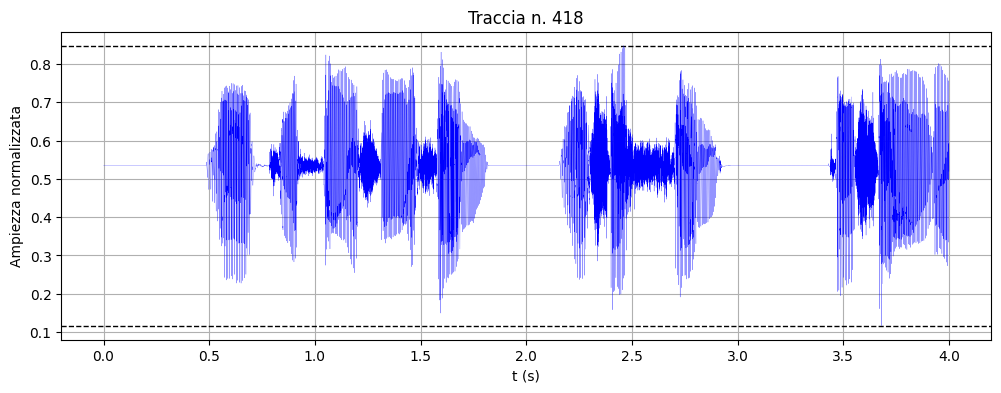

In [ ]:
plot_audio(audio=audio_norm, audio_rec=False, i=r, sr=sample_rate, reconstruction_plot=False, zoom=False)

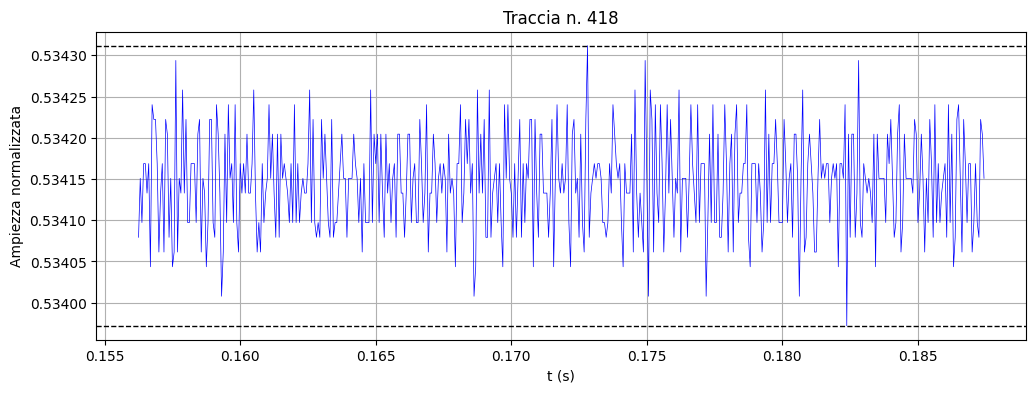

In [ ]:
# Esempio:
plot_audio(audio=audio_norm, audio_rec=False, i=r, sr=sample_rate, reconstruction_plot=False, zoom=[2500,3000])

# **AutoEncoder Convoluzionale**





### **Preparazione dataset per training e validation**

In [ ]:
# Importazione librerie e moduli di PyTorch
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

import time # per poter misurare il tempo durante il training del modello

import warnings
warnings.filterwarnings('ignore') # filtro per omettere il print dei warning delle varie librerie

###### Riduzione della dimensione dei campioni ed estrazione frammenti casuali delle tracce

In [ ]:
# Funzione che estrae un frammento (casuale o non) della dimensione desiderata da ciascuna traccia
def cutter(dataset, n, rand):
  if rand: # i frammenti vengono estrapolati in punti diversi del file
    trimmed_data = []
    for row in dataset:
      a = random.randint(0, lenght - n)
      trimmed_data.append(row[a:a+n])
  else:    # i frammenti vengono raccolti tutti nello stesso punto
      a = random.randint(0, lenght - n)
      trimmed_data = [row[a:a+n] for row in dataset]
  return trimmed_data

In [ ]:
# DIMENSIONE DEL CAMPIONE DA TAGLIARE
#----------------------------------------------------------------------------------------------
n_trim = 4800
#----------------------------------------------------------------------------------------------

t_sample_trim = np.arange(0, n_trim,1)/sample_rate

# "taglio" del dataset a shape (445, n_trim)
audio_cut = np.array(cutter(audio_norm, n_trim, rand=True))
print(f'dataset shape: {audio_cut.shape}')

dataset shape: (445, 4800)


###### **Creazione dataset train/validation**

In [ ]:
batch_n = 1                                              # IMPOSTAZIONE DELLA DIMENSIONE DEL BATCH

labels = labels.reshape((-1, 1))                         # rimodella le etichette in un array 2D con forma (numero di labels, 1)
labels = torch.Tensor(labels).int()                      # converte l'array 'labels' in un tensore Torch di interi

audio_cut = torch.Tensor(audio_cut).float()              # converte i dati audio in un tensore Torch a 32-bit floating point

dataset_audio = TensorDataset(audio_cut,labels)          # creazione TensorDataset a partire dal tensore audio

# creazione dei dataset per training e validation
dataset_train, dataset_val = random_split(dataset_audio,                                                    # divisione dataset audio in due parti:
                                          [int(0.8*(len(dataset_audio))), int(0.2*(len(dataset_audio)))])   # 80% training set / 20% validation set
# creazione DataLoader generale
audio_dl = DataLoader(dataset_audio, batch_size=batch_n, shuffle=False, num_workers=1, drop_last=True)

# creazione DataLoader per il training set
audio_dl_train = DataLoader(dataset_train, batch_size=batch_n, shuffle=False, num_workers=1, drop_last=True)

# creazione DataLoader per il validation set
audio_dl_val = DataLoader(dataset_val, batch_size=batch_n, shuffle=False, num_workers=1, drop_last=True)

audio_b_train, label_train = next(iter(audio_dl_train))   # estrazione primo batch dal DataLoader di training
audio_b_train = audio_b_train.reshape(audio_b_train.shape[0], 1, audio_b_train.shape[1]) # definizione forma del tensore per avere canali  alla 2a componente

audio_b_val, label_val = next(iter(audio_dl_val))         # estrazione primo batch dal DataLoader di validation
audio_b_val = audio_b_val.reshape(audio_b_val.shape[0], 1, audio_b_val.shape[1]) # definizione forma del tensore per avere i canali alla seconda componente

# check delle dimensioni dei tensori di training e validation
print(f'training   : {audio_b_train.shape}')
print(f'validation : {audio_b_val.shape}')

training   : torch.Size([1, 1, 4800])
validation : torch.Size([1, 1, 4800])


### **Implementazione AE e training del modello**

 ###### **Definizione della classe per l'AutoEncoder Convoluzionale (1D)**


In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self, encoder_size, decoder_size, latent_dim, kernel_size, stride, padding, dropout):
        super(AutoEncoder, self).__init__()
        self.encoder_size = encoder_size            # dim. dei layer dell'encoder
        self.decoder_size = decoder_size            # dim. dei layer del decoder
        self.latent_dim = latent_dim                # dim. dello spazio latente
        layers1 = []                                # layers dell'encoder
        layers2 = []                                # layers del decoder

    # Encoder ------------------------------------------------------------------------------------------------------------------------------------------------

        # layers di convoluzione, il primo in_channels è 1 (un solo canale essendo file audio)
        for i in range(len(self.encoder_size)):
            if i==0:  # primo layer
                layers1.append(nn.Conv1d(in_channels=1, out_channels=self.encoder_size[i],
                                         kernel_size=kernel_size[i], stride=stride[i], padding=padding[i]))
            else:     # layer successivo, in_channels è l'out_channels del layer precedente
                layers1.append(nn.Conv1d(in_channels=self.encoder_size[i - 1], out_channels=self.encoder_size[i],
                                         kernel_size=kernel_size[i], stride=stride[i], padding=padding[i]))

            layers1.append(nn.ReLU())                               # funzione di attivazione ReLU

            if dropout: layers1.append(nn.Dropout(dropout))         # dropout per regolarizzazione

        self.Encoder = nn.Sequential(*layers1)                      # creazione encoder da sequenza dei layer

        # output dell'encoder per mappare allo spazio latente
        self.OutEncoder = nn.Conv1d(in_channels=self.encoder_size[-1], out_channels=self.latent_dim,
                                    kernel_size=kernel_size[-1], stride=stride[-1], padding=padding[-1])

    # Decoder ------------------------------------------------------------------------------------------------------------------------------------------------

        for i in range(len(self.decoder_size)):
            if i==0:  # primo layer convoluzione trasposta
                layers2.append(nn.ConvTranspose1d(in_channels=self.latent_dim, out_channels=self.decoder_size[i],
                                                  kernel_size=kernel_size[i], stride=stride[i], padding=padding[i]))
            else:     # layer successivo
                layers2.append(nn.ConvTranspose1d(in_channels=self.decoder_size[i - 1], out_channels=self.decoder_size[i],
                                                  kernel_size=kernel_size[i], stride=stride[i], padding=padding[i]))

            layers2.append(nn.ReLU())                               # funzione di attivazione ReLU

            if dropout: layers2.append(nn.Dropout(dropout))         # dropout per regolarizzazione

        self.Decoder = nn.Sequential(*layers2)                      # crazione decoder come sequenza dei layer

        # output del decoder per ricostruire l'input iniziale
        self.OutDecoder = nn.ConvTranspose1d(in_channels=self.decoder_size[-1], out_channels=1,
                                             kernel_size=kernel_size[-1], stride=stride[-1], padding=padding[-1])


    # Rappresentazione latente e ricostruzione ---------------------------------------------------------------------------------------------------------------

    def forward(self, x):
        x = self.Encoder(x)                           # manda l'input attraverso l'encoder
        z = self.OutEncoder(x)                        # viene mappato l'output dell'encoder nello spazio latente

        x = self.Decoder(z)                           # decodifica la rappresentazione latente per ricostruire l'input originale.
        x_rec = self.OutDecoder(x)                    # restituisce direttamente l'output del decoder

        return z, x_rec


    # Compilatore del modello : definizione della loss, opt e stampa del sommario ----------------------------------------------------------------------------

    def compile(self, lr, Scheduler, scheduler_params=None):
        global criterion
        global opt
        global scheduler

        if torch.cuda.is_available(): model.cuda()    # trasferimento del modello alla GPU se disponibile

        criterion = nn.SmoothL1Loss()
        opt = optim.Adam(model.parameters(), lr=lr)

        # Inizializzazione scheduler
        if Scheduler: scheduler = ReduceLROnPlateau(opt, **scheduler_params)
        else: scheduler = None

        # Generazione sommario dettagliato del modello (sia nel caso in cui si usa la GPU, sia quando si usa la CPU)
        if torch.cuda.is_available(): summary(model.cuda(), input_size=(1, audio_b_train.shape[2]))
        else: summary(model, input_size=(1, audio_b_train.shape[2]))


    # Salvataggio dei file audio ricostruiti -----------------------------------------------------------------------------------------------------------------

    def save(self, dir, audio_rec, lenght_vector, sr):
        audio_rec = audio_rec.detach().numpy()                       # i vettori vengono converiti in array numpy
        folder = f'/content/ReconstructedAudios_{dir}'              # costituzione nome cartella
        os.makedirs(folder, exist_ok=True)                           # creazione cartella

        for i in range(audio_rec.shape[0]):
            filename = f'{folder}/reconstructed_audio_{i+1:3d}.wav'  # creazione percorso del file
            write(filename, sr, audio_rec[i])                        # scrittura del file (percorso, frequenza, dati audio) in formato .wav
        print(f'Audio ricostruiti salvati in "{folder}"')


    # Allenamento del modello --------------------------------------------------------------------------------------------------------------------------------

    def fit(self, epochs):
        t_loss = []                                     # train loss
        v_loss = []                                     # validation loss
        folder = '/content/TrainingCheckpointers_Folder'
        os.makedirs(folder, exist_ok=True)              # creazione cartella per checkpointers di PyTorch

        for epoch in range(epochs):                     # ciclo per eseguire il training per il numero di epoche inserito
            t0 = time.time()                            # registrazione tempo di inizio dell'epoca

        # TRAINING

            model.train()                               # impostazione del modello in modalità di training
            train_loss = 0                              # inizializzazione loss del training
            counter = 0                                 # inizializzazione contatore per i batch

            for xb, _ in audio_dl_train:                # ciclo su tutti i batch del DataLoader di training
                if isinstance(xb, list):
                  xb = torch.stack(xb)                  # conversione in tensore Torch se il batch è una lista
                xb = xb.view(batch_n, 1, xb.shape[1])   # rimodella il tensor 'xb' per aggiungere la dimensione del canale
                if torch.cuda.is_available():           # muove l'input nella GPU se è disponibile
                    xb = xb.cuda()
                counter += 1                            # incremento contatore dei batch di training

                z, pred = model(xb)                     # applicazione del modello

                loss = criterion(pred, xb)              # CALCOLO DELLA LOSS TRA L'OUTPUT DEL MODELLO E L'INPUT
                train_loss += loss.item()               # incremento loss totale

                # backpropagation
                opt.zero_grad()                         # azzeramento dei gradienti accumulati
                loss.backward()                         # calcolo dei gradienti tramite backpropagation
                opt.step()                              # aggiornamento dei parametri del modello

            train_loss /= counter                       # calcolo della loss media per l'epoca
            t_loss.append(train_loss)

        # VALIDATION

            model.eval()                                # impostazione del modello in modalità di valutazione
            val_loss = 0                                # inizializzazione loss
            counter = 0                                 # inizializzazione contatore sui batch di validation

            with torch.no_grad():                       # disattivazione calcolo dei gradienti
                for xb, _ in audio_dl_val:              # ciclo sui batch del DataLoader di validation
                  if isinstance(xb, list): xb = torch.stack(xb)
                  xb = xb.view(batch_n, 1, xb.shape[1])
                  if torch.cuda.is_available(): xb = xb.cuda()
                  counter += 1                          # incremento contatore dei batch di validation

                  z, pred = model(xb)                   # applicazione del modello

                  loss = criterion(pred, xb)            # CALCOLO DELLA LOSS
                  val_loss += loss.item()               # incremento loss totale

            val_loss /= counter                         # loss media per l'epoca di validation
            v_loss.append(val_loss)

            if scheduler: scheduler.step(val_loss)      # aggiorna il learning rate in base alla validation loss

        # OUTPUT

            # salvataggio parametri del modello ogni 20 epoche
            if (epoch + 1) % 20 == 0: torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': opt.state_dict(),
                           'train_loss': train_loss,'val_loss': val_loss,}, f'{folder}/training_checkpoint{epoch:3d}.pth')

            elapsed_time = time.time() - t0             # tempo impiegato per l'esecuzione di un'epoca
            print(f"epoch: {epoch+1:4d} \t time(s): {elapsed_time:.4f} \t train loss: {train_loss:.8f} \t val loss: {val_loss:.8f}")

        return t_loss, v_loss


# Inizializzazione dei pesi della rete neurale con il metodo Xavier/Glorot -----------------------------------------------------------------------------------

def weights_init_glorot(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
        init.xavier_uniform_(m.weight)
        if m.bias is not None: init.constant_(m.bias, 0)

##### **Definizione del modello**

In [ ]:
# Definizione del modello ------------------------------------------------------------------------------------------------------------------------------------

model = AutoEncoder(encoder_size = [16,8],     # dimensioni layer dell'encoder
                    decoder_size = [8,16],     # dimensioni layer del decoder
                    latent_dim = 5,            # dimensione dello spazio latente
                    kernel_size = [4,4,4],     # dimensione del kernel per effettuare le operazioni di convoluzione
                    stride = [2,2,2],          # step della convoluzione
                    padding = [1,1,1],         # padding della convoluzione
                    dropout = False)           # dropout rimosso

# Applicazione della funzione di inizializzazione dei pesi ---------------------------------------------------------------------------------------------------

model.apply(weights_init_glorot)

# Definizione parametri per lo scheduler ---------------------------------------------------------------------------------------------------------------------

scheduler_params = {'mode': 'min',                             # loss minimizzata
                    'factor': 0.01,                            # fattore di riduzione del learning rate
                    'patience': 5,                             # n. epoche dopo le quali ridurre il learning rate
                    'verbose': True}

# Compilazione del modello -----------------------------------------------------------------------------------------------------------------------------------

model.compile(lr=0.003, Scheduler=True, scheduler_params=scheduler_params)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 2400]              80
              ReLU-2             [-1, 16, 2400]               0
            Conv1d-3              [-1, 8, 1200]             520
              ReLU-4              [-1, 8, 1200]               0
            Conv1d-5               [-1, 5, 600]             165
   ConvTranspose1d-6              [-1, 8, 1200]             168
              ReLU-7              [-1, 8, 1200]               0
   ConvTranspose1d-8             [-1, 16, 2400]             528
              ReLU-9             [-1, 16, 2400]               0
  ConvTranspose1d-10              [-1, 1, 4800]              65
Total params: 1,526
Trainable params: 1,526
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.52
Params size (MB): 0.01
Estimated Total

##### **Addestramento del modello (TRAINING)**

In [ ]:
epochs_n = 100                                                # numero di epoche del training

t_loss, v_loss = model.fit(epochs = epochs_n)                 # attributo di classe che allena il modello, restituendo loss (train/val) per ogni epoca
torch.save(model.state_dict(), 'AutoEncoder_Model.pth')       # SALVATAGGIO PARAMETRI DELL'ALLENAMENTO

epoch:    1 	 time(s): 1.8739 	 train loss: 0.00462932 	 val loss: 0.00017977
epoch:    2 	 time(s): 2.0275 	 train loss: 0.00029916 	 val loss: 0.00011856
epoch:    3 	 time(s): 2.4869 	 train loss: 0.00024146 	 val loss: 0.00010272
epoch:    4 	 time(s): 1.9831 	 train loss: 0.00022025 	 val loss: 0.00009999
epoch:    5 	 time(s): 1.8592 	 train loss: 0.00020527 	 val loss: 0.00009382
epoch:    6 	 time(s): 1.8628 	 train loss: 0.00018636 	 val loss: 0.00008941
epoch:    7 	 time(s): 1.8086 	 train loss: 0.00017399 	 val loss: 0.00008232
epoch:    8 	 time(s): 1.8057 	 train loss: 0.00014468 	 val loss: 0.00007747
epoch:    9 	 time(s): 2.1272 	 train loss: 0.00012864 	 val loss: 0.00007497
epoch:   10 	 time(s): 2.6211 	 train loss: 0.00013291 	 val loss: 0.00006992
epoch:   11 	 time(s): 1.8985 	 train loss: 0.00010674 	 val loss: 0.00006847
epoch:   12 	 time(s): 1.8481 	 train loss: 0.00009824 	 val loss: 0.00006407
epoch:   13 	 time(s): 1.8505 	 train loss: 0.00009287 	 val los

##### **Plot della loss**

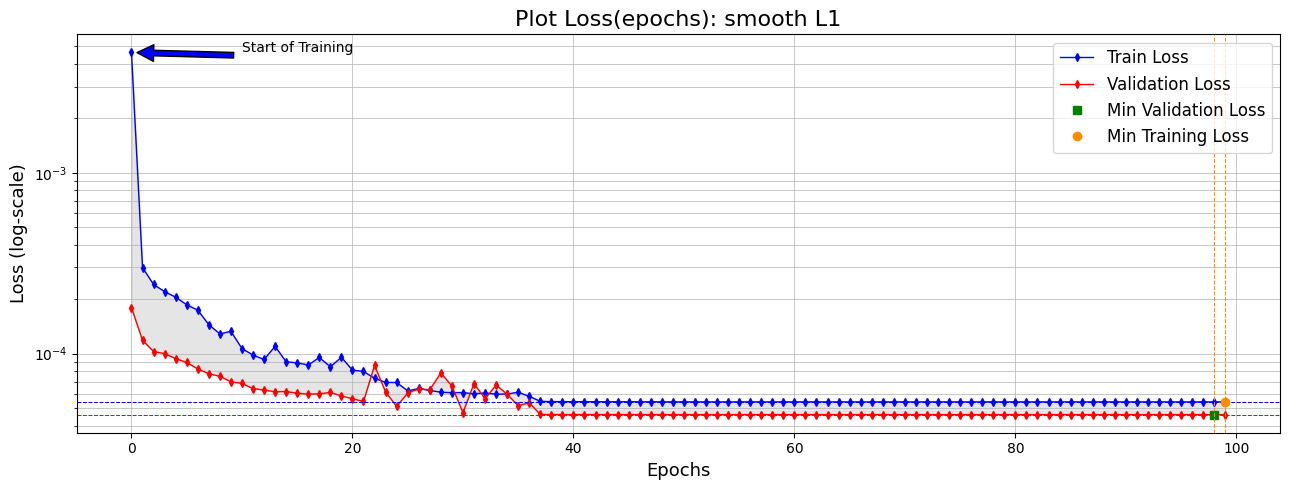

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(np.arange(0, epochs_n, 1), t_loss, '-b', marker='d', label="Train Loss", markersize=4, linewidth=1)
ax.plot(np.arange(0, epochs_n, 1), v_loss, '-r', marker='d', label="Validation Loss", markersize=4, linewidth=1)

ax.set_xlabel('Epochs', fontsize=13)
ax.set_ylabel('Loss (log-scale)', fontsize=13)
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='-', linewidth=0.5)
ax.annotate('Start of Training', xy=(0, t_loss[0]), xytext=(10, t_loss[0]), arrowprops=dict(facecolor='blue', shrink=0.05))

min_v_loss_epoch = np.argmin(v_loss)
min_v_loss_value = np.min(v_loss)
ax.plot(min_v_loss_epoch, min_v_loss_value, 's', color='green', label='Min Validation Loss')
ax.axhline(y=min_v_loss_value, color='r', linestyle='--', linewidth=0.75)
ax.axvline(x=min_v_loss_epoch, color='darkorange', linestyle='--', linewidth=0.75)

min_t_loss_epoch = np.argmin(t_loss)
min_t_loss_value = np.min(t_loss)
ax.axhline(y=min_t_loss_value, color='b', linestyle='--', linewidth=0.75)
ax.axvline(x=min_t_loss_epoch, color='darkorange', linestyle='--', linewidth=0.75)
ax.plot(min_t_loss_epoch, min_t_loss_value, 'o', color='darkorange', label='Min Training Loss')

ax.fill_between(np.arange(0, epochs_n, 1), t_loss[:epochs_n], v_loss[:epochs_n], color='gray', alpha=0.2)

plt.title('Plot Loss(epochs): smooth L1',fontsize=16)
ax.legend(loc='upper right', fontsize=12)
fig.tight_layout()
plt.show()

 ### **Ricostruzione tracce audio**

#### Funzione per ricostruzione tracce audio e plot
Si utilizza una funzione *Reconstruction*, che prende in ingresso gli elementi da ricostruire, la lunghezza dell'audio, la loss, e una variabile booleana *save_rec* che, se vera, consente il salvataggio degli audio ricostruiti in formato *.waw* in una cartella di Colab, il cui nome viene completato dall'utente. La estrapola dal modello la ricostruzione del dataset di training (attraverso l'encoder) e ne calcola la loss.

In [ ]:
# Funzione per la ricostruzione delle tracce audio --------------------------------------------------------------------------------------------------------------------------------

def Reconstruction(data, len_audio, out_loss, criterion, save_rec, sr, string):
    output = []
    if torch.cuda.is_available(): model.cuda()                # garantisce compatibilità del modello con GPU se disponibile

    with torch.no_grad():                                     # evita che vengano cacolati automaticamente i gradienti
      for xb in data:
        if isinstance(xb, list): xb = torch.stack(xb)
        xb = xb.view(xb.shape[1], 1, len_audio)               # reshape di xb per adattarla al modello
        if torch.cuda.is_available(): xb = xb.cuda()          # spostamento del batch su GPU se disponibile
        _, x_rec = model(xb)                                  # attraverso il modello si ottiene l'output ricostruito di xb
        # '_' è la rappresentazione latente data dall'encoder (non necessaria ai fini della ricostruzione)
        # 'x_rec' è la ricostruzione degli audio originali a partire dalla rappresentazione latente.
        loss = criterion(x_rec, xb)                           # loss tra output ricostruito e input originale
        out_loss+=loss.item()
        output.append(x_rec.cpu())                            # spostamento dell'output sulla CPU

    output = torch.tensor(np.array(output))                   # conversione della lista di output in un tensore
    output = output.reshape(output.shape[0], len_audio)
    print(f'loss:  {out_loss}\nshape: {output.shape}')

    if save_rec:                                              # se save_rec=True, gli audio ricostruiti vengono salvati
      model.save(string, output, len_audio, sr)               # attributo di classe che salva gli audio nella cartella "Reconstructed_Audios_{stringa}"

    return output, out_loss                                   # restituisce l'output della ricostruzione e la loss totale

# Funzione per la creazione del grafico dei residui -------------------------------------------------------------------------------------------------------------------------------

def plot_residual(reconstructed, original, i, sr, zoom):
    if zoom:
      t = np.arange(zoom[0], zoom[1], 1) / sample_rate
      x = original[i][zoom[0]:zoom[1]]
      x_rec = reconstructed[i][zoom[0]:zoom[1]]
    else:
      t = np.arange(0, len(original[i]), 1) / sample_rate
      x = original[i]
      x_rec = reconstructed[i]
    plt.subplots(figsize=(12, 4))
    plt.plot(t, x_rec - x , '.', color='g', markersize=2, label='Residui tra traccia originale e ricostruita')
    plt.xlabel("Time (s)")
    plt.ylabel("Ampiezza del residuo: $y_{originale}-y_{ricostruito}$")
    plt.title(f'Grafico dei residui per la traccia n. {i+1}')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Retta di riferimento per y=0')
    max_residual_idx = np.argmax(np.abs(x_rec - x))
    plt.plot(t[max_residual_idx], x_rec[max_residual_idx] - x[max_residual_idx], 'o', color='darkorange', markersize=6, label='Residuo massimo')
    plt.legend(loc='best',fontsize=9)
    plt.show()

#### Prova di ricostruzione e plot di un frammento

In [ ]:
# Creazione Dataset e Dataloader a partire dal tensore audio_cut iniziale con batch=1,
# per valutare e ricostruire le tracce singolarmente e raggrupparle tutte insieme senza problemi di dimensione -----------------------------------------------

batch_eval = 1

dataset_audio = TensorDataset(audio_cut)
audio_dl_eval = DataLoader(dataset_audio, batch_size=batch_eval, shuffle=False, num_workers=0, drop_last=True)

# Ricostruzione ----------------------------------------------------------------------------------------------------------------------------------------------

model.eval()                                # modello in modalità valutazione
eval_loss = 0                               # inizializzazione loss di valutazione a zero
criterion = nn.SmoothL1Loss()               # loss per la valutazione, Smooth L1 Loss (Huber)

x_rec_plot , eval_loss = Reconstruction(audio_dl_eval, n_trim, eval_loss, criterion,
                                        save_rec=False, sr=False, string=False)

loss:  0.023360898233761418
shape: torch.Size([445, 4800])


In [ ]:
# Plot di una traccia audio casuale con la sua ricostruzione
rp = random.randint(0, x_rec_plot.shape[0]-1)

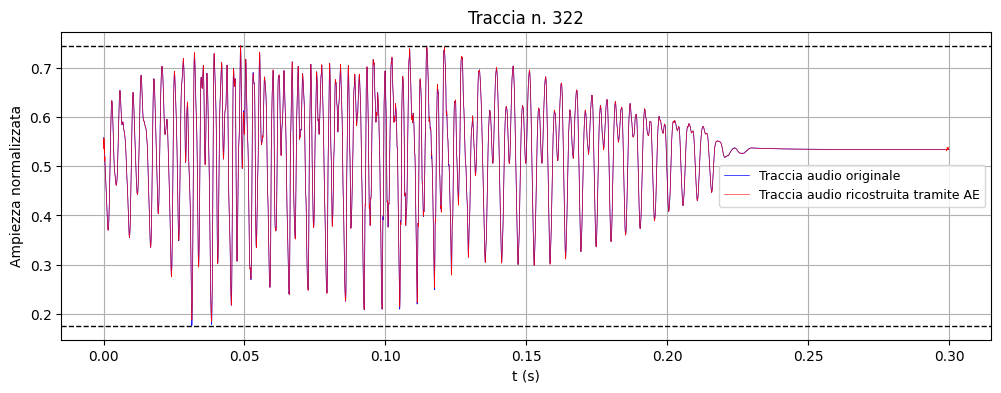

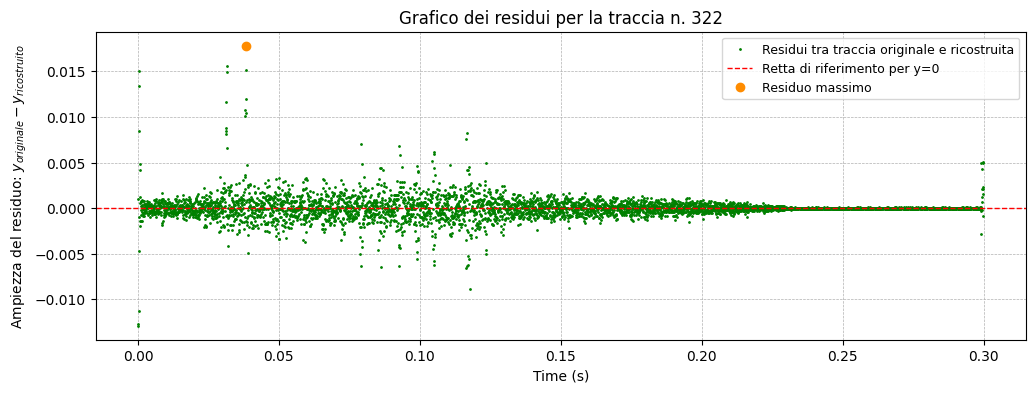

In [ ]:
plot_audio(audio=audio_cut, audio_rec=x_rec_plot, i=rp, sr=sample_rate, reconstruction_plot=True, zoom=[0,n_trim])
plot_residual(reconstructed=x_rec_plot, original=audio_cut , i=rp, sr=sample_rate, zoom=False)

#### Salvataggio audio interi ricostruiti

In [ ]:
# lunghezza con cui salvare le tracce audio ricostruite (in questo caso vengono ricostruiti per intero)
#------------------------------------------------------------------------------------------------------
n_trim_save = 64000
#------------------------------------------------------------------------------------------------------

# Conversione in tensore Torch e creazione DataLoader --------------------------------------------------------------------------------------------------------

audio_cut_save = torch.Tensor(np.array(cutter(audio_norm, n_trim_save, rand=False))).float()
dataset_audio_save = TensorDataset(audio_cut_save)
audio_dl_save = DataLoader(dataset_audio_save, batch_size=1, shuffle=False, num_workers=0, drop_last=True)

# Ricostruzione e salvataggio nella cartella "Reconstructed_Audios_Gruppo0" ----------------------------------------------------------------------------------

model.eval()
save_loss = 0

x_rec_save , save_loss = Reconstruction(audio_dl_save,n_trim_save, save_loss, criterion,
                                        save_rec=True, sr=sample_rate, string='Gruppo0')

loss:  0.020442218449955085
shape: torch.Size([445, 64000])
Audio ricostruiti salvati in "/content/ReconstructedAudios_Gruppo0"


In [ ]:
# Plot di un audio ricostruita salvata casuale
rc = random.randint(0, x_rec_save.shape[0]-1)

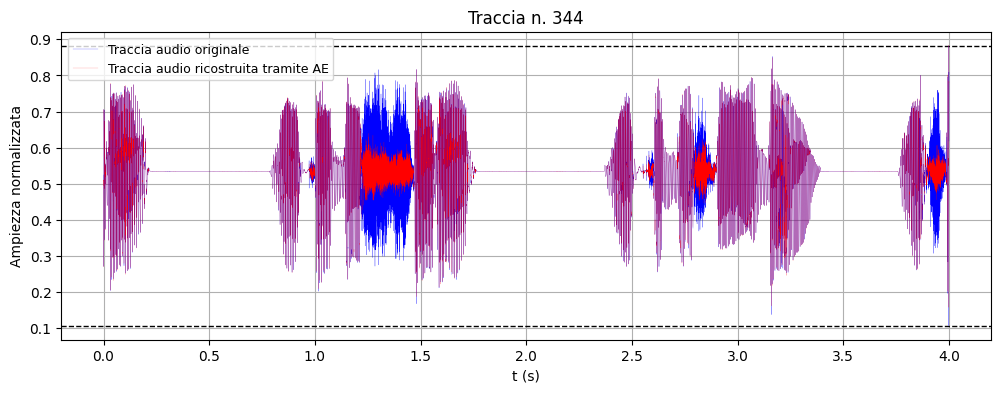

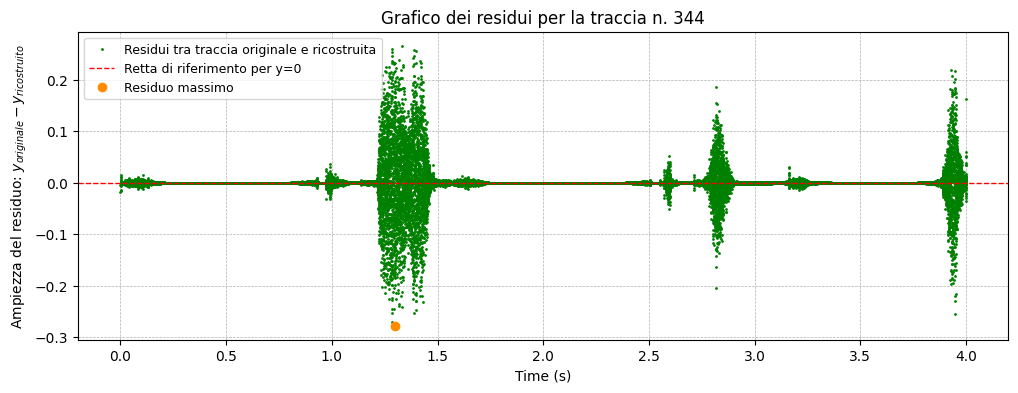

In [ ]:
plot_audio(audio=audio_cut_save, audio_rec=x_rec_save, i=rc, sr=sample_rate, reconstruction_plot=True, zoom=False)
plot_residual(reconstructed=x_rec_save, original=audio_cut_save , i=rc, sr=sample_rate, zoom=False)

#### **Istogrammi degli errori ed errori di ricostruzione per classe**

errore medio di ricostruzione: 1.0499e-04


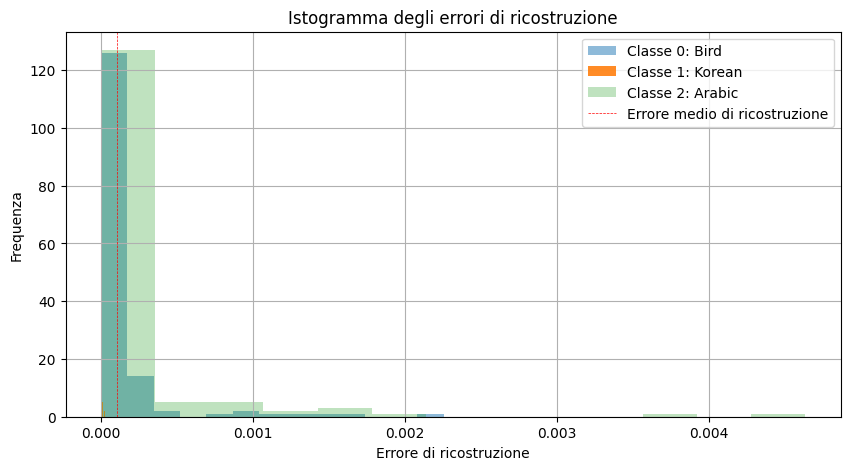

In [ ]:
model.eval()                                                               # impostazione del modello in modalità valutazione

# Calcolo errori di ricostruzione ----------------------------------------------------------------------------------------------------------------------------

true_labels = []
rec_errors = []

with torch.no_grad():
    for xb, yb in audio_dl:
        if isinstance(xb, list): xb = torch.stack(xb)
        xb = xb.view(xb.size(0), 1, -1)
        if torch.cuda.is_available():
                xb = xb.cuda()
                yb = yb.cuda()

        encoded, decoded = model(xb)                                       # applicazione del modello

        error = torch.mean((decoded - xb)**2, dim=[1, 2])                  # calcolo dell'errore medio tra l'output ricostruito e l'input originale
        rec_errors.extend(error.cpu().numpy())                             # porta i dati alla CPU e converte gli errori da tensori ad arrays
        true_labels.extend(yb.cpu().numpy())                               # converte le labels originali 'yb' da tensori ad arrays

true_labels = np.array(true_labels)
reconstruction_errors = np.array(rec_errors)

print(f'errore medio di ricostruzione: {np.mean(reconstruction_errors):.4e}')  # errore medio di ricostruzione

class_rec_errors = {0: [], 1: [], 2: []}                                   # dizionario per gli errori di ogni classe
for true_label, error in zip(true_labels, reconstruction_errors):
    class_rec_errors[int(true_label.item())].append(error)                 # errore di ricostruzione per classe

# Istogramma degli errori di ricostruzione per ogni classe ---------------------------------------------------------------------------------------------------

# Dizionario per i nomi delle classi e altri parametri
label_names = {0: 'Bird', 1: 'Korean', 2: 'Arabic'}
alpha_values = {0: 0.5, 1: 0.9, 2: 0.3}
colors = {0: 'blue', 1: 'orange', 2: 'lime'}

plt.figure(figsize=(10, 5))
for label, errors in class_rec_errors.items():
    plt.hist(errors, bins=13, alpha=alpha_values[label], histtype='bar', label=f'Classe {label}: {label_names[label]}', density=False, stacked=True)
plt.axvline(x=np.mean(reconstruction_errors), color='r', linestyle='--', linewidth=0.5, label='Errore medio di ricostruzione')
plt.xlabel('Errore di ricostruzione')
plt.ylabel('Frequenza')
plt.title('Istogramma degli errori di ricostruzione')
plt.grid()
plt.legend()
plt.show()

errori medi per classe:
 classe 0: 1.1529e-04
 classe 1: 3.9546e-06
 classe 2: 1.9886e-04


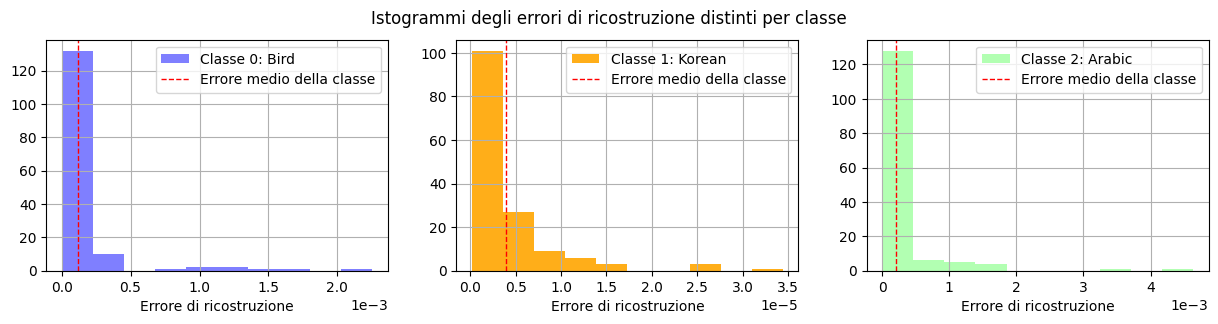

In [ ]:
print('errori medi per classe:')
for  label, errors in class_rec_errors.items():
  print(f' classe {label}: {np.mean(errors):.4e}')

# Plot degli istogrammi degli errori di ricostruzione distinti per classe
plt.figure(figsize=(15, 3))
for label, errors in class_rec_errors.items():
    plt.subplot(1, 3, label + 1)
    plt.xlabel('Errore di ricostruzione')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.grid()
    plt.hist(errors, bins=10, alpha=alpha_values[label], histtype='bar', label=f'Classe {label}: {label_names[label]}', density=False, stacked=False, color=colors[label])
    plt.axvline(x=np.mean(errors), color='r', linestyle='--', linewidth=1, label='Errore medio della classe')
    plt.legend()
plt.suptitle('Istogrammi degli errori di ricostruzione distinti per classe')
plt.show()

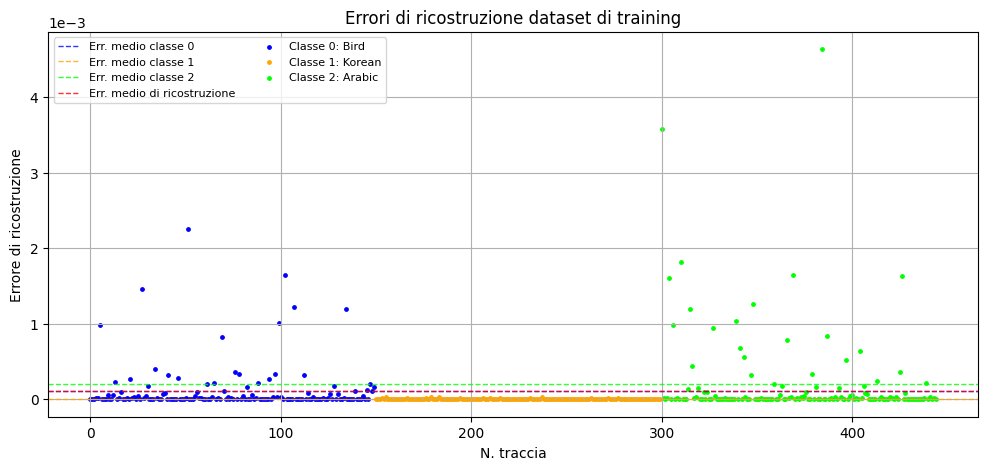

In [ ]:
plt.figure(figsize=(12, 5))
plt.grid()
plt.xlabel('N. traccia')
plt.ylabel('Errore di ricostruzione')
plt.title('Errori di ricostruzione dataset di training')
added_labels = set()
for  label, errors in class_rec_errors.items():
  plt.axhline(y=np.mean(errors), color=colors[label], linestyle='--', linewidth=1,label=f'Err. medio classe {label}', alpha = 0.8)
plt.axhline(y=np.mean(reconstruction_errors), color='r', linestyle='--', linewidth=1, label='Err. medio di ricostruzione', alpha=0.8)
for i, (error, label) in enumerate(zip(reconstruction_errors, true_labels)):
    lbl = int(label)
    if lbl not in added_labels:
        plt.scatter(i, error, color=colors[lbl], label=f'Classe {lbl}: {label_names[lbl]}', s=6)
        added_labels.add(lbl)
    else:
        plt.scatter(i, error, color=colors[lbl], s=6)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
handles, lbls = plt.gca().get_legend_handles_labels()
by_label = dict(zip(lbls, handles))
plt.legend(by_label.values(), by_label.keys())
plt.legend(loc='best', fontsize=8, ncols=2)


### **Plot dello spazio latente tramite riduzione dimensionale con UMAP**

In [ ]:
# Installazione e importazione di UMAP
!pip install umap-learn
import umap

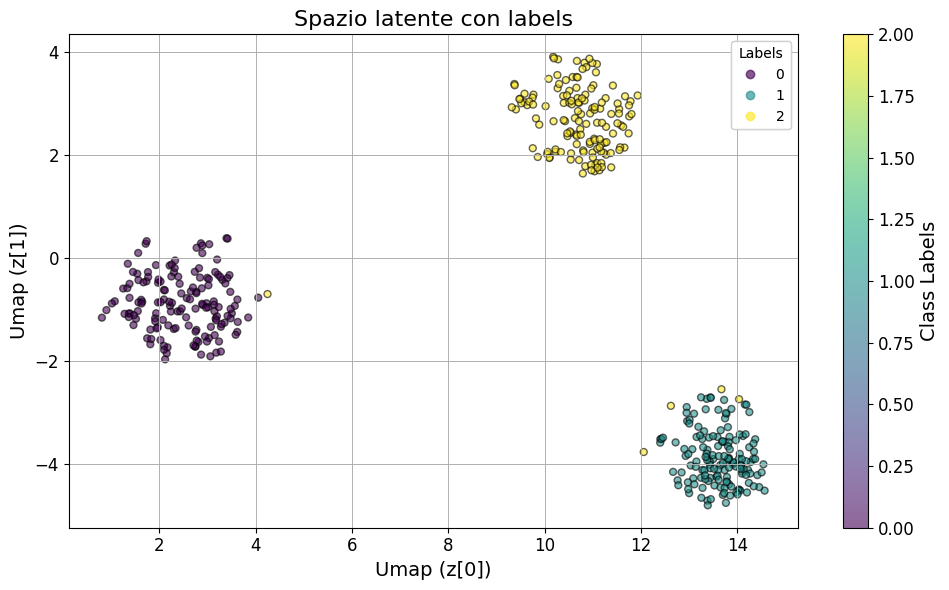

In [ ]:
audio_data = audio_cut                                    # dati audio senza label

# Conversione dati audio in tensore PyTorch, impostazione tipo a float32, aggiunta dimensione per il canale
audio_data = torch.tensor(audio_cut.clone().detach(), dtype=torch.float32).unsqueeze(1)

batch_size = batch_n                                      # dimensione del batch

# Creazione dataset e DataLoader
dataset = TensorDataset(audio_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Estrazione delle rappresentazioni latenti ------------------------------------------------------------------------------------------------------------------

latent_rep = []                                           # inizializza una lista per memorizzare le rappresentazioni latenti

with torch.no_grad():
    for xb in dataloader:
        xb = xb[0]
        if torch.cuda.is_available(): xb = xb.cuda()

        z, _ = model(xb)                                  # rappresentazione latente dal modello (data dall'output ddell'encoder)
        latent_rep.append(z)

latent_representations = torch.cat(latent_rep, dim=0)     # concatenazione rapp. latenti in un unico tensore
# Rimozione gradienti, spostamento su CPU, conversione in numpy e reshape
latent_representations = latent_representations.detach().cpu().numpy().reshape(len(dataset), -1)

#si applica UMAP per ridurre la dimensionalità a 2

manifold = umap.UMAP().fit(latent_representations, labels)  # applica UMAP
latent_representations_2d = manifold.transform(latent_representations)  # trasformazione rapp. latenti in 2D


# Scatter Plot dello spazio latente --------------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], c=labels, s=25, alpha=0.6, edgecolor='k', cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend)
ax.set_title("Spazio latente con labels", fontsize=16)
ax.set_xlabel("Umap (z[0])", fontsize=14)
ax.set_ylabel("Umap (z[1])", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.grid(True, which='both', linestyle='-', linewidth=0.7)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Class Labels', fontsize=14)
cbar.ax.tick_params(labelsize=12)
fig.tight_layout()
plt.show()

# **Analisi del dataset di Test** ```gruppo_27```




###**Estrazione e preparazione dei dati**

##### Estrazione da zip e normalizzazione file audio


In [ ]:
# Funzione per lettura dati da file audio
def wav_file_reading(zip, folder):
  audio_data = []
  sample_rate = []
  test_paths = []
  with zipfile.ZipFile(zip, 'r') as zip_ref:
      zip_ref.extractall(folder)
      for file_name in zip_ref.namelist():
          if file_name.endswith('.wav'):
              file_path = os.path.join(folder, file_name)
              test_paths.append(file_path)
              sr, data = wavfile.read(file_path)
              sample_rate.append(sr)
              audio_data.append(data.astype(float))
  return test_paths, sample_rate, audio_data

In [ ]:
# Ricerca percorso e creazione cartella dei file estratti
zip_file_path = '/content/gruppo_27.zip'
extract_dir = 'gruppo_27'
os.makedirs(extract_dir, exist_ok=True)

# LETTURA DATI DA FILE E NORMALIZZAZIONE
test_paths, sample_rates, audio_data_set = wav_file_reading(zip_file_path,extract_dir)

audio_norm_test = Normalize([np.array(data) for data in audio_data_set])

n_test_paths = len(test_paths)

for i in range(n_test_paths):
  print(f"{i+1:3d})  {test_paths[i]} / freq: {sample_rates[i]/1000}kHz / dim.: {len(audio_norm_test[i])} / data: {audio_norm_test[i]} ")
print(f'\nnumero di file contenuti nel dataset: {n_test_paths}')

In [ ]:
# Plot traccia casuale
rt = random.randint(0, n_test_paths-1)

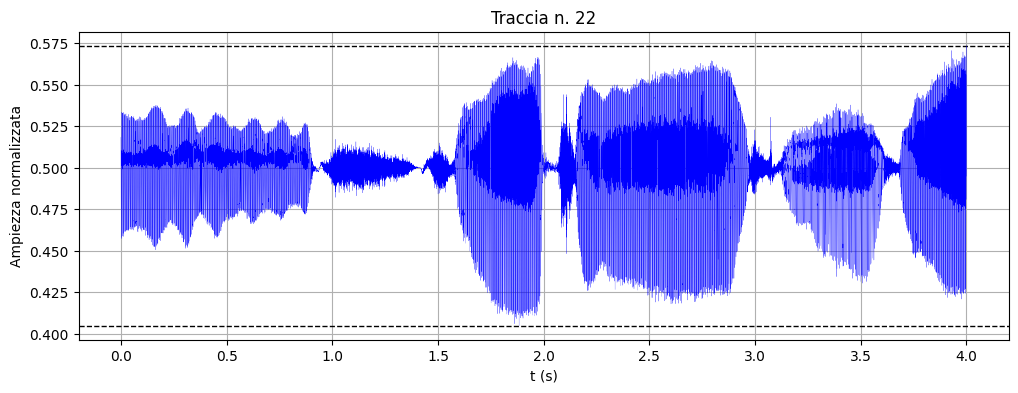

In [ ]:
plot_audio(audio=audio_norm_test, audio_rec=False, i=rt, sr=sample_rates[rt], reconstruction_plot=False, zoom=False)

##### Rimozione tracce fuori shape

In [ ]:
lenght = 64000

# indici della lunghezza definita
index_keep = [index for index, array in enumerate(audio_norm_test) if len(array) == lenght]
print(f'tracce di dimensione =/= {lenght}: {[index for index, audio_norm_test[index] in enumerate(audio_norm_test) if len(audio_norm_test[index])!=lenght]}')

# si filtrano i file audio
audio_norm_test = np.array([audio_norm_test[index] for index in index_keep])
test_paths = np.array([test_paths[index] for index in index_keep])
n = len(audio_norm_test)
print(f'numero di file di dim. {lenght}: {n}')

tracce di dimensione =/= 64000: [20]
numero di file di dim. 64000: 69


### **Applicazione del modello al dataset di test**

##### Taglio della lunghezza dei file audio

In [ ]:
# DIMENSIONE DEL CAMPIONE DA TAGLIARE
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
n_trim_test = 64000                         # si considerano le tracce audio per intero
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

audio_cut_test = torch.Tensor(np.array(cutter(audio_norm_test, n_trim_test, rand=False))) #conversione in tensore Torch

print(audio_cut_test.shape) # shape check

torch.Size([69, 64000])


##### Creazione DataLoader e ricostruzione dei dati

In [ ]:
# Creazione TensorDataset e DataLoader a partire dal tensore audio -------------------------------------------------------------------------------------------

batch_test = 1
dataset_audio = TensorDataset(audio_cut_test)
audio_dl_test = DataLoader(dataset_audio, batch_size=batch_test, shuffle=False)

# Ricostruzione e salvataggio nella cartella "Reconstructed_Audios_Gruppo_27" --------------------------------------------------------------------------------

model.eval()
test_loss = 0
criterion = nn.SmoothL1Loss()

x_rec_test , test_loss = Reconstruction(audio_dl_test, n_trim_test, test_loss, criterion,
                                        save_rec=True, sr=16000, string="Gruppo27")

loss:  0.0034266530680397977
shape: torch.Size([69, 64000])
Audio ricostruiti salvati in "/content/ReconstructedAudios_Gruppo27"


In [ ]:
# Plot traccia audio casuale con ricostruzione
if batch_test == 1: sb = random.randint(0,x_rec_test.shape[0]-1)
else: sb = random.randint(0, batch_test-1)

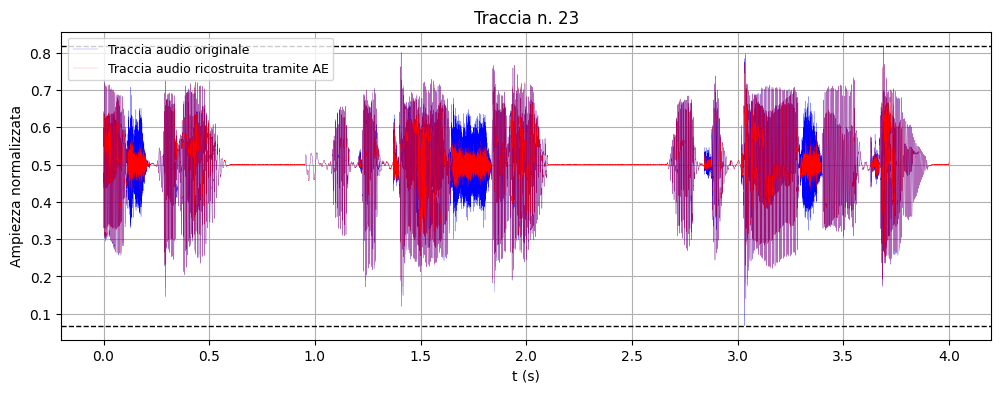

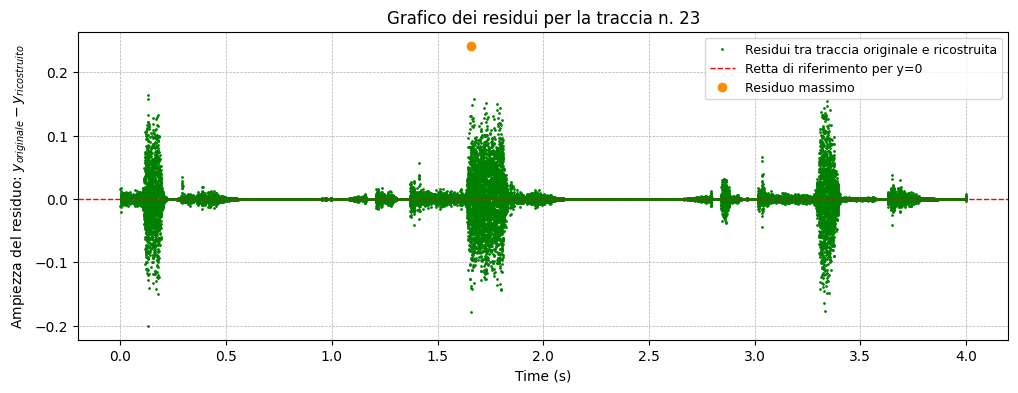

In [ ]:
plot_audio(audio=audio_cut_test, audio_rec=x_rec_test, i=sb, sr=sample_rates[sb], reconstruction_plot=True, zoom=False)
plot_residual(reconstructed=x_rec_test, original=audio_cut_test , i=sb, sr=sample_rates[sb], zoom=False)

### **Scatter plot dello spazio latente sul dataset di test**

Scatter plot ottenuto nella medesima maniera di quello realizzato sul dataset di train, con l'unica differenza di avere dati diversi da dover rappresentare.

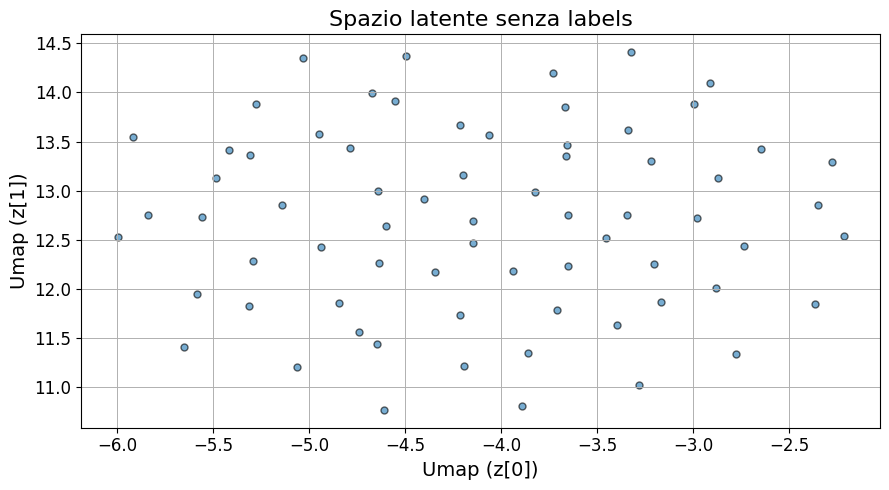

In [ ]:
# Conversione dati audio in tensore PyTorch, impostazione tipo a float32, aggiunta dimensione per il canale
audio_data = torch.tensor(audio_cut_test.clone().detach(), dtype=torch.float32).unsqueeze(1)

batch_size = batch_test                                      # dimensione del batch

# Creazione dataset e DataLoader
dataset = TensorDataset(audio_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Estrazione delle rappresentazioni latenti ------------------------------------------------------------------------------------------------------------------

latent_rep = []                                           # inizializza una lista per memorizzare le rappresentazioni latenti

with torch.no_grad():
    for xb in dataloader:
        xb = xb[0]
        if torch.cuda.is_available(): xb = xb.cuda()

        z, _ = model(xb)                                  # rappresentazione latente dal modello (data dall'output ddell'encoder)
        latent_rep.append(z)

latent_representations = torch.cat(latent_rep, dim=0)     # concatenazione rapp. latenti in un unico tensore
# Rimozione gradienti, spostamento su CPU, conversione in numpy e reshape
latent_representations = latent_representations.detach().cpu().numpy().reshape(len(dataset), -1)

#si applica UMAP per ridurre la dimensionalità a 2

manifold = umap.UMAP().fit(latent_representations)  # applica UMAP
latent_representations_2d = manifold.transform(latent_representations)  # trasformazione rapp. latenti in 2D


# Scatter Plot dello spazio latente --------------------------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9, 5))
scatter = ax.scatter(latent_representations_2d[:, 0], latent_representations_2d[:, 1], s=25, alpha=0.6, edgecolor='k', cmap='viridis')
ax.set_title("Spazio latente senza labels", fontsize=16)
ax.set_xlabel("Umap (z[0])", fontsize=14)
ax.set_ylabel("Umap (z[1])", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.grid(True, which='both', linestyle='-', linewidth=0.7)
fig.tight_layout()
plt.show()

### **Anomaly detection e classificazione del dataset di test**


KMeans(algorithm='elkan', max_iter=1000, n_clusters=3, n_init=300, tol=0.001)

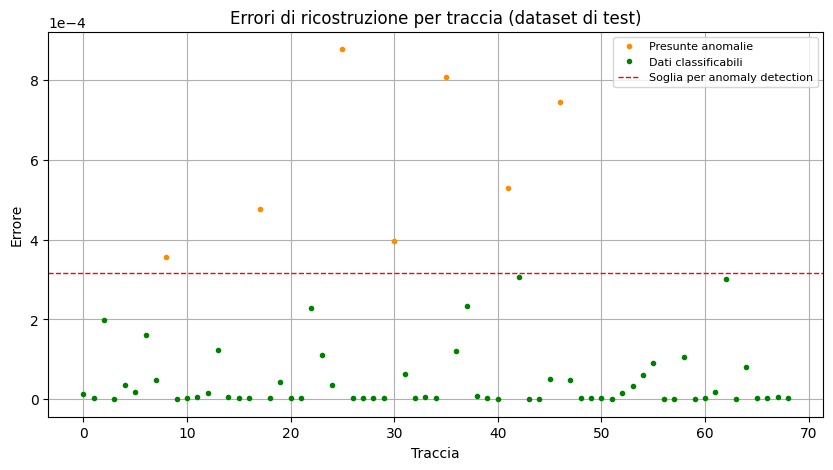

In [ ]:
from sklearn.cluster import KMeans, DBSCAN

# Estrazione delle rappresentazioni latenti (ottenuta sempre nella stessa maniera)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
latent_representations = []
latent_vectors = []
errors = []

with torch.no_grad():
    for xb in audio_dl_test:
        if isinstance(xb, list): xb = torch.stack(xb)
        xb = xb.view(xb.shape[1], 1, n_trim_test)
        if torch.cuda.is_available(): xb = xb.cuda()
        encoded, decoded = model(xb)
        latent_representations.append(encoded)
        decoded = decoded.reshape(xb.shape)
        error = torch.mean((decoded - xb) ** 2, dim=[1, 2])
        errors.append(error.cpu().numpy())
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Calcolo errore per le anomalie
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
errors = np.concatenate(errors)

threshold = np.percentile(errors, 90) # SOGLIA PER ANOMALY DETECTION
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Plot degli errori di ricotruzione per traccia con soglia per l'anomaly detection
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
x = np.arange(0, n, 1)
plt.plot(x[errors >= threshold], errors[errors >= threshold], '.', color='darkorange', label='Presunte anomalie')
plt.plot(x[errors < threshold],errors[errors < threshold], '.', color='green', label= 'Dati classificabili')
plt.xlabel('Traccia')
plt.ylabel('Errore')
plt.title('Errori di ricostruzione per traccia (dataset di test)')
plt.axhline(y=threshold,color='red', linestyle='--', linewidth=1,label='Soglia per anomaly detection')
plt.grid()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='best',fontsize=8)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------


latent_representations = torch.cat(latent_representations, dim=0)
latent_representations = latent_representations.detach().cpu().numpy().reshape(len(dataset_audio), -1)

# Riduzione dimensionale con UMAP
manifold1 = umap.UMAP(n_neighbors=3, min_dist=0.01, n_components=2).fit(latent_representations)
latent_representations_2d = manifold1.transform(latent_representations)

# Clustering delle rappresentazioni latenti
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=300, max_iter=1000, tol=1e-3, random_state=None, algorithm="elkan")
kmeans.fit(latent_representations_2d)

Anomaly Detection : anomalie rispetto alle classi del training (soglia = 0.000317):
  1)	[ 8]  file n. 9	 gruppo_27/TQz4FRKEPqy35Gr.wav
  2)	[17]  file n.18	 gruppo_27/l68azDToU9i8xZR.wav
  3)	[25]  file n.26	 gruppo_27/r7S4Euz3acM7NyU.wav
  4)	[30]  file n.31	 gruppo_27/lXKEbkPMuoq7imF.wav
  5)	[35]  file n.36	 gruppo_27/zxU0fvmn4Lgte7x.wav
  6)	[41]  file n.42	 gruppo_27/jLql98A6XOKZiOi.wav
  7)	[46]  file n.47	 gruppo_27/AfAEVk4Kb6HjaoW.wav


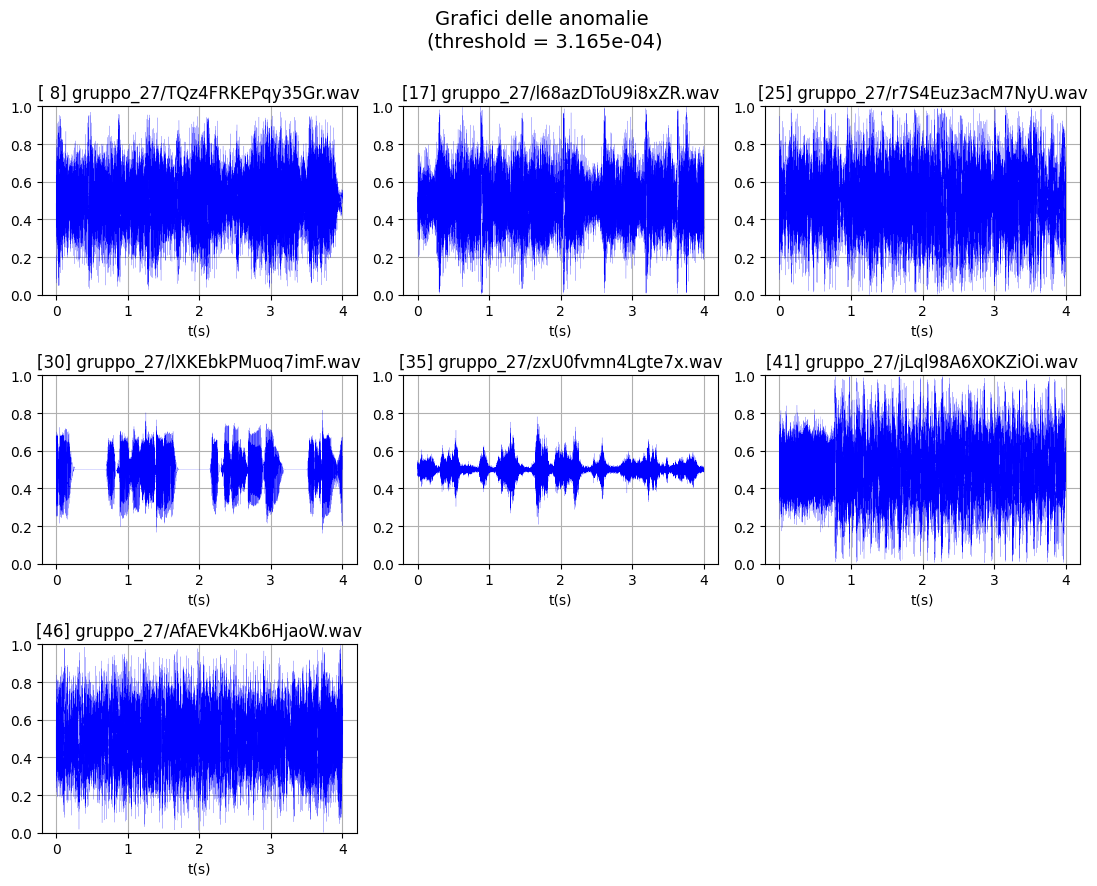

Classificazione:
 [['gruppo_27/HEFUCQQNFI64jsq.wav', 0], ['gruppo_27/mORBrLImS2EkcuQ.wav', 1], ['gruppo_27/QGF0rP4GlIn4Zow.wav', 1], ['gruppo_27/VWe4k9bE6vMFsT1.wav', 1], ['gruppo_27/b7LNU8mpy5xUJNF.wav', 1], ['gruppo_27/5dPcjCXgm0aSlOL.wav', 0], ['gruppo_27/ItYSFXJQNhfOKgt.wav', 0], ['gruppo_27/6xpmYdFEmhajBTz.wav', 1], ['gruppo_27/TQz4FRKEPqy35Gr.wav', -1], ['gruppo_27/IgWtVZqIX4Sqv75.wav', 2], ['gruppo_27/MjmnvEZWlTECM96.wav', 1], ['gruppo_27/ICxrZghcNF0qCNv.wav', 0], ['gruppo_27/g8asbRT01rjokkk.wav', 2], ['gruppo_27/dbY1DkHGNLtpAYx.wav', 0], ['gruppo_27/ZlduiYwk68PEBJ3.wav', 1], ['gruppo_27/1vy1vVQ1gEm7ha6.wav', 1], ['gruppo_27/t7jbAs96m8wwgdS.wav', 2], ['gruppo_27/l68azDToU9i8xZR.wav', -1], ['gruppo_27/PumTPoRCsrKzKmQ.wav', 1], ['gruppo_27/GBF0viJfbktyEkC.wav', 1], ['gruppo_27/WrmJ6BTIhZBmmLd.wav', 0], ['gruppo_27/wE8Mp2K2xSLXGur.wav', 1], ['gruppo_27/Wxt4uDLLnKQAVtz.wav', 2], ['gruppo_27/5do9bfnae6ogV16.wav', 1], ['gruppo_27/ucuCL8aYc8xe6ii.wav', 2], ['gruppo_27/r7S4Euz3acM7NyU.w

In [ ]:
# ANOMALY DETECTION E CLASSIFICAZIONE
file_labels = []
labels_previsti = []

print(f'Anomaly Detection : anomalie rispetto alle classi del training (soglia = {threshold:.6f}):')

c = 0
a = 0
anomaly_plots = []

# Vengono estratte le rappresentazioni latenti una per volta. Quindi singolarmente per ogni punto dello spazio latente, si calcola l'errore e si verifica se è un anomalia,
# in caso contrario si assegna il suo label per la classe tramite la classificazione con K-Means
with torch.no_grad():
    for path, xb in zip(test_paths, audio_dl_test):
        if isinstance(xb, list): xb = torch.stack(xb)
        xb = xb.view(xb.shape[1], 1, n_trim_test)
        if torch.cuda.is_available(): xb = xb.cuda()

        encoded, decoded = model(xb)
        decoded = decoded.reshape(xb.shape)
        error = torch.mean((decoded - xb) ** 2, dim=[1, 2])

        latent_point = latent_representations_2d[c, :]
        latent_point = latent_point.reshape(-1, 2)
        target = kmeans.predict(latent_point)

        if error > threshold:
            label = -1  # anomalia
            a += 1
            print(f'{a:3d})\t[{c:2d}]  file n.{c+1:2d}\t {path}')
            # servirà per il plot del grafico della traccia dell'anomalia osservata
            fig, ax = plt.subplots()
            ax.plot(xb.cpu().numpy().flatten())
            ax.set_title(f'[{c:2d}] {path}', fontsize=5)
            anomaly_plots.append((fig, ax))
            plt.close(fig)

        else:
            label = target[0]  # assegnazione del cluster nel caso in cui il punto non rappresenti un anomalia

        labels_previsti.append(label)
        file_labels.append([path, label])
        c += 1

if a == 0: print('\t nessuna anomalia rilevata\n')
else:
    num_plots = len(anomaly_plots)
    cols = 3
    rows = (num_plots + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(11, rows * 3))
    fig.suptitle(f'Grafici delle anomalie \n(threshold = {threshold:.3e})\n', fontsize=14)

    axs = axs.flatten()
    for i, (plot_fig, plot_ax) in enumerate(anomaly_plots):
      # Plot dei grafici delle anomalie osservate
        axs[i].set_ylim(0, 1)
        axs[i].plot(plot_ax.lines[0].get_xdata()/sample_rate, plot_ax.lines[0].get_ydata(), linewidth = 0.1, color = 'b')
        axs[i].grid()
        axs[i].set_title(plot_ax.get_title())
        axs[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axs[i].set_xlabel('t(s)')

    for i in range(len(anomaly_plots), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

print(f'Classificazione:\n {file_labels}\n\n')

#### Salvataggio su file .csv

In [ ]:
gruppo_27_df = pd.DataFrame(file_labels, columns=['filename', 'label'])
gruppo_27_df.to_csv('Gruppo_27_with_Labels.csv', index=True)
display(gruppo_27_df)

,filename,label
0,gruppo_27/HEFUCQQNFI64jsq.wav,0
1,gruppo_27/mORBrLImS2EkcuQ.wav,1
2,gruppo_27/QGF0rP4GlIn4Zow.wav,1
3,gruppo_27/VWe4k9bE6vMFsT1.wav,1
4,gruppo_27/b7LNU8mpy5xUJNF.wav,1
...,...,...
64,gruppo_27/7MTEntGg8lHgm2q.wav,1
65,gruppo_27/utXzu2FtOJqydBq.wav,2
66,gruppo_27/udZcsRLLJiot6ZN.wav,1
67,gruppo_27/G2f8LO85vXS1CQ4.wav,0
